<a href="https://colab.research.google.com/github/SaketMunda/introduction-to-nlp/blob/master/exercises_nlp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Exercises on Natural Language Processing with TensorFlow

- [x] Rebuild, compile and train model_1, model_2 and model_5 using the [Keras Sequential API](https://www.tensorflow.org/api_docs/python/tf/keras/Sequential) instead of the Functional API.
- [x] Retrain the baseline model with 10% of the training data. How does perform compared to the Universal Sentence Encoder model with 10% of the training data?
- [x] Try fine-tuning the TF Hub Universal Sentence Encoder model by setting training=True when instantiating it as a Keras layer.

```
# We can use this encoding layer in place of our text_vectorizer and embedding layer
sentence_encoder_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        input_shape=[],
                                        dtype=tf.string,
                                        trainable=True) # turn training on to fine-tune the TensorFlow Hub model
```
- [x] Retrain the best model you've got so far on the whole training set (no validation split). Then use this trained model to make predictions on the test dataset and format the predictions into the same format as the sample_submission.csv file from Kaggle (see the Files tab in Colab for what the sample_submission.csv file looks like). Once you've done this, [make a submission to the Kaggle competition](https://www.kaggle.com/c/nlp-getting-started/data), how did your model perform?
- [x] Combine the ensemble predictions using the majority vote (mode), how does this perform compare to averaging the prediction probabilities of each model?
- [x] Make a confusion matrix with the best performing model's predictions on the validation set and the validation ground truth labels.

## Get ready with the Data

In [1]:
# First checking the prerequisite for this exercise notebook
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-99035247-f8b4-de3c-648d-8fe38e82d1c7)


In [2]:
# import the helper function
!wget https://raw.githubusercontent.com/SaketMunda/ml-helpers/master/helper_functions.py

from helper_functions import unzip_data, create_tensorboard_callback

--2023-02-28 03:07:57--  https://raw.githubusercontent.com/SaketMunda/ml-helpers/master/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2904 (2.8K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]   2.84K  --.-KB/s    in 0s      

2023-02-28 03:07:57 (37.9 MB/s) - ‘helper_functions.py’ saved [2904/2904]



In [3]:
# import the dataset of tweets
!wget https://storage.googleapis.com/ztm_tf_course/nlp_getting_started.zip

# unzip the data
unzip_data('nlp_getting_started.zip')

--2023-02-28 03:08:01--  https://storage.googleapis.com/ztm_tf_course/nlp_getting_started.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.194.128, 64.233.170.128, 74.125.68.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.194.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 607343 (593K) [application/zip]
Saving to: ‘nlp_getting_started.zip’

nlp_getting_started 100%[===================>] 593.11K  --.-KB/s    in 0.004s  

2023-02-28 03:08:01 (143 MB/s) - ‘nlp_getting_started.zip’ saved [607343/607343]



In [38]:
# visualize the text dataset
import pandas as pd
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

# shapes
train_df.shape, test_df.shape

((7613, 5), (3263, 4))

In [ ]:
# view any samples
train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [5]:
# need to reshuffle the training dataset
train_shuffled_df = train_df.sample(frac=1, random_state=17)
train_shuffled_df.head()

,id,keyword,location,text,target
7027,10072,typhoon,NaN,Typhoon Soudelor: When will it hit Taiwan ÛÒ ...,1
318,463,armageddon,NaN,RT @RTRRTcoach: #Love #TrueLove #romance lith ...,0
1681,2425,collide,www.youtube.com?Malkavius2,I liked a @YouTube video from @gassymexican ht...,0
5131,7318,nuclear%20reactor,"New York, New York",Japan's Restart of Nuclear Reactor Fleet Fast ...,1
2967,4262,drowning,"Hendersonville, NC",#ICYMI #Annoucement from Al Jackson... http://...,0


In [6]:
# split the training and test set from the train_shuffled_df
from sklearn.model_selection import train_test_split

train_sentences, val_sentences, train_labels, val_labels = train_test_split(train_shuffled_df['text'].to_numpy(),
                                                                              train_shuffled_df['target'].to_numpy(),
                                                                              test_size=0.1,
                                                                              random_state=17)

In [7]:
# Text Vectorizer & Embedding Layer
import tensorflow as tf
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from tensorflow.keras import layers

max_vocab_length = 10000
max_length = 15
# using the default vectorizor variables
text_vectorizer = TextVectorization(max_tokens=max_vocab_length,
                                    output_mode='int',
                                    output_sequence_length=max_length)

# fit the text vectorizer to the training text
text_vectorizer.adapt(train_sentences)

# creating the embedding layer
embedding = layers.Embedding(input_dim=max_vocab_length,
                             output_dim=128,
                             embeddings_initializer='uniform',
                             input_length=max_length,
                             name='embedding_1')

## 1. Rebuild, Compile and Train model_1, model_2 and model_5 using the Keras Sequential API instead of the Functional API


Brief about each models,

- `model_1` : Simple Dense Model
- `model_2` : LSTM (RNN)
- `model_5` : 1D (CNN)


### Model_1 : Simple Dense Model using Sequential API

In [29]:
from tensorflow.keras import layers

SAVE_DIR='model_logs'

# Build model with Sequential API
model_1 = tf.keras.Sequential([
    layers.Input(shape=(1,), dtype=tf.string),
    text_vectorizer,
    embedding,
    layers.GlobalAveragePooling1D(),
    layers.Dense(1, activation='sigmoid', name='model_1_sequential_dense')
])

# compile the model
model_1.compile(loss='binary_crossentropy',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

# fit the model
history_1 = model_1.fit(train_sentences,
                        train_labels,
                        epochs=5,
                        validation_data=(val_sentences, val_labels),
                        callbacks=[create_tensorboard_callback(dir_name=SAVE_DIR,
                                                                experiment_name='model_1_sequential')])

Saving Tensorboard log files to: model_logs/model_1_sequential/20230228-043827
Epoch 1/5
215/215 [==============================] - 14s 59ms/step - loss: 0.6121 - accuracy: 0.6987 - val_loss: 0.5280 - val_accuracy: 0.7677
Epoch 2/5
215/215 [==============================] - 2s 10ms/step - loss: 0.4440 - accuracy: 0.8202 - val_loss: 0.4633 - val_accuracy: 0.7861
Epoch 3/5
215/215 [==============================] - 3s 15ms/step - loss: 0.3479 - accuracy: 0.8629 - val_loss: 0.4599 - val_accuracy: 0.7953
Epoch 4/5
215/215 [==============================] - 2s 8ms/step - loss: 0.2844 - accuracy: 0.8892 - val_loss: 0.4697 - val_accuracy: 0.7979
Epoch 5/5
215/215 [==============================] - 2s 8ms/step - loss: 0.2374 - accuracy: 0.9115 - val_loss: 0.4878 - val_accuracy: 0.7887


In [30]:
model_1_results = model_1.evaluate(val_sentences, val_labels)
model_1_results

24/24 [==============================] - 0s 5ms/step - loss: 0.4878 - accuracy: 0.7887


[0.4878462851047516, 0.7887139320373535]

### Model_2 : LSTM (RNN)

In [31]:
# create new embeddings
model_2_embedding = layers.Embedding(input_dim=max_vocab_length,
                                     output_dim=128,
                                     embeddings_initializer='uniform',
                                     input_length=max_length,
                                     name='embeding_2')

# Create the model
model_2 = tf.keras.Sequential([
    layers.Input(shape=(1,), dtype=tf.string),
    text_vectorizer,
    model_2_embedding,
    layers.LSTM(64),
    layers.Dense(1, activation='sigmoid')    
])

# compile the model
model_2.compile(loss='binary_crossentropy',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

# fit the model
model_2_history = model_2.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(dir_name=SAVE_DIR,
                                                                     experiment_name='model_2_LSTM')])

Saving Tensorboard log files to: model_logs/model_2_LSTM/20230228-043909
Epoch 1/5
215/215 [==============================] - 13s 41ms/step - loss: 0.5163 - accuracy: 0.7435 - val_loss: 0.4464 - val_accuracy: 0.8045
Epoch 2/5
215/215 [==============================] - 3s 14ms/step - loss: 0.3162 - accuracy: 0.8724 - val_loss: 0.5186 - val_accuracy: 0.7835
Epoch 3/5
215/215 [==============================] - 2s 10ms/step - loss: 0.2156 - accuracy: 0.9200 - val_loss: 0.6362 - val_accuracy: 0.7559
Epoch 4/5
215/215 [==============================] - 2s 9ms/step - loss: 0.1561 - accuracy: 0.9451 - val_loss: 0.6315 - val_accuracy: 0.7756
Epoch 5/5
215/215 [==============================] - 2s 8ms/step - loss: 0.1061 - accuracy: 0.9600 - val_loss: 0.7628 - val_accuracy: 0.7651


In [32]:
model_2_results = model_2.evaluate(val_sentences,val_labels)
model_2_results

24/24 [==============================] - 0s 4ms/step - loss: 0.7628 - accuracy: 0.7651


[0.7628372311592102, 0.7650918364524841]

### Model_5 : 1D CNN

In [33]:
# create embeddings
model_5_embedding = layers.Embedding(input_dim=max_vocab_length,
                                     output_dim=128,
                                     embeddings_initializer='uniform',
                                     input_length=max_length,
                                     name='model_5_embedding')

# create the model
model_5 = tf.keras.Sequential([
    layers.Input(shape=(1,), dtype=tf.string),
    text_vectorizer,
    model_5_embedding,
    layers.Conv1D(filters=32, kernel_size=5, strides=1, activation='relu', padding='valid'),
    layers.GlobalMaxPool1D(),
    layers.Dense(1, activation='sigmoid', name='model_5_CNN')
])

# compile the model
model_5.compile(loss='binary_crossentropy',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

# fit the model
model_5_history = model_5.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(dir_name=SAVE_DIR,
                                                                      experiment_name='model_5_CNN')])



Saving Tensorboard log files to: model_logs/model_5_CNN/20230228-043931
Epoch 1/5
215/215 [==============================] - 17s 52ms/step - loss: 0.5637 - accuracy: 0.7209 - val_loss: 0.4605 - val_accuracy: 0.8005
Epoch 2/5
215/215 [==============================] - 4s 18ms/step - loss: 0.3404 - accuracy: 0.8606 - val_loss: 0.4969 - val_accuracy: 0.7822
Epoch 3/5
215/215 [==============================] - 2s 10ms/step - loss: 0.2104 - accuracy: 0.9251 - val_loss: 0.5636 - val_accuracy: 0.7769
Epoch 4/5
215/215 [==============================] - 2s 9ms/step - loss: 0.1370 - accuracy: 0.9561 - val_loss: 0.6571 - val_accuracy: 0.7756
Epoch 5/5
215/215 [==============================] - 3s 12ms/step - loss: 0.0968 - accuracy: 0.9693 - val_loss: 0.7242 - val_accuracy: 0.7664


In [34]:
model_5_results = model_5.evaluate(val_sentences, val_labels)
model_5_results

24/24 [==============================] - 0s 6ms/step - loss: 0.7242 - accuracy: 0.7664


[0.7242047786712646, 0.7664042115211487]

## Retrain the `baseline` model with 10% data

In [ ]:
# Select only the 10% of random data
train_10_percent_df = train_df.sample(frac=0.1, random_state=17)
train_10_percent_df.shape

(761, 5)

In [ ]:
# create training and validation data
from sklearn.model_selection import train_test_split

train_sentences, val_sentences, train_labels, val_labels = train_test_split(train_10_percent_df['text'].to_numpy(),
                                                                            train_10_percent_df['target'].to_numpy(),
                                                                            test_size=0.1,
                                                                            random_state=17)

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

model_0 = Pipeline([
    ("tfidf", TfidfVectorizer()),
    ("clf", MultinomialNB())
])

# Fit the pipeline to the training data
model_0.fit(train_sentences, train_labels)

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [ ]:
# baseline_scores with 10% of data
baseline_10_percent_score = model_0.score(val_sentences, val_labels)
baseline_10_percent_score

0.8051948051948052

It looks like our baseline_10_percent_score still beating the universal sentence encoder results which was trained with 10% of data

## Try fine-tuning the TF Hub Universal Sentence Encoder model by setting training=True when instantiating it as a Keras layer.

```
# We can use this encoding layer in place of our text_vectorizer and embedding layer
sentence_encoder_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        input_shape=[],
                                        dtype=tf.string,
                                        trainable=True) # turn training on to fine-tune the TensorFlow Hub model
```



In [8]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers

# universal sentence encoder layer
sentence_encoder_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        input_shape=[],
                                        dtype=tf.string,
                                        trainable=True,
                                        name="USE")

# create the model
model_USE = tf.keras.Sequential([
    sentence_encoder_layer,
    layers.Dense(64, activation='relu'),
    layers.Dense(1, activation='sigmoid', name='output_layer')
], name='model_use_finetune')

# compile the model
model_USE.compile(loss='binary_crossentropy',
                  optimizer=tf.keras.optimizers.Adam(),
                  metrics=['accuracy'])

# fit the model
history_USE = model_USE.fit(train_sentences,
                            train_labels,
                            epochs=5,
                            validation_data=(val_sentences, val_labels))

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


Epoch 1/5
215/215 [==============================] - 145s 506ms/step - loss: 0.4483 - accuracy: 0.8021 - val_loss: 0.4659 - val_accuracy: 0.7966
Epoch 2/5
215/215 [==============================] - 29s 133ms/step - loss: 0.2368 - accuracy: 0.9094 - val_loss: 0.6337 - val_accuracy: 0.7323
Epoch 3/5
215/215 [==============================] - 34s 157ms/step - loss: 0.0812 - accuracy: 0.9737 - val_loss: 0.5618 - val_accuracy: 0.8045
Epoch 4/5
215/215 [==============================] - 24s 110ms/step - loss: 0.0419 - accuracy: 0.9853 - val_loss: 0.5825 - val_accuracy: 0.8005
Epoch 5/5
215/215 [==============================] - 24s 112ms/step - loss: 0.0273 - accuracy: 0.9899 - val_loss: 0.6350 - val_accuracy: 0.8018


In [9]:
model_USE_results = model_USE.evaluate(val_sentences, val_labels)
model_USE_results

24/24 [==============================] - 0s 13ms/step - loss: 0.6350 - accuracy: 0.8018


[0.635006308555603, 0.8018372654914856]

In [10]:
model_USE.summary()

Model: "model_use_finetune"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 USE (KerasLayer)            (None, 512)               256797824 
                                                                 
 dense (Dense)               (None, 64)                32832     
                                                                 
 output_layer (Dense)        (None, 1)                 65        
                                                                 
Total params: 256,830,721
Trainable params: 256,830,721
Non-trainable params: 0
_________________________________________________________________


## Retrain the best model you've got so far on the whole training set (no validation split). 

Then use this trained model to make predictions on the test dataset and format the predictions into the same format as the sample_submission.csv file from Kaggle (see the Files tab in Colab for what the sample_submission.csv file looks like). Once you've done this, [make a submission to the Kaggle competition](https://www.kaggle.com/c/nlp-getting-started/data), how did your model perform?

Get the data ready first, we have whole training set in `train_shuffled_df`, just we need to separate the texts and targets

In [11]:
train_shuffled_df.head()

,id,keyword,location,text,target
7027,10072,typhoon,NaN,Typhoon Soudelor: When will it hit Taiwan ÛÒ ...,1
318,463,armageddon,NaN,RT @RTRRTcoach: #Love #TrueLove #romance lith ...,0
1681,2425,collide,www.youtube.com?Malkavius2,I liked a @YouTube video from @gassymexican ht...,0
5131,7318,nuclear%20reactor,"New York, New York",Japan's Restart of Nuclear Reactor Fleet Fast ...,1
2967,4262,drowning,"Hendersonville, NC",#ICYMI #Annoucement from Al Jackson... http://...,0


In [12]:
whole_train_sentences = train_shuffled_df['text']
whole_train_labels = train_shuffled_df['target']

In [15]:
# check the test data
test_df.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [13]:
# Training the ensemble model with whole training data

# import the tf-idf vectorizer to convert text into numbers
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

best_model = Pipeline([
    ("tfidf", TfidfVectorizer()),
    ("clf", MultinomialNB())
])

best_model.fit(whole_train_sentences, whole_train_labels)

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [16]:
best_model_preds = best_model.predict(test_df['text'])
best_model_pred_probs = best_model.predict_proba(test_df['text'])

In [17]:
# view the predictions
best_model_preds

array([1, 0, 1, ..., 1, 1, 1])

In [20]:
# view the prediction probs
best_model_pred_probs.max(axis=1)

array([0.52241526, 0.6061398 , 0.57637294, ..., 0.77950238, 0.85677581,
       0.70510377])

In [26]:
# copy the dataframe for results
submission_df = test_df

submission_df['target'] = best_model_preds

submission_df.drop(labels=['keyword', 'location', 'text'], axis=1, inplace=True)

In [28]:
# export to csv
submission_df.to_csv('submission.csv', index=False)

After the Submission, the model produces results of 79% accuracy.

## Combine the ensemble predictions using the majority vote (mode), how does this perform compare to averaging the prediction probabilities of each model?

- `model_5` : Conv1D
- `model_2` : LSTM
- `model_USE` : TFHub

Let's get the predictions from each model and perform the majority model experiment,

In [39]:
test_sentences = test_df['text']

# check the shapes
test_sentences.shape

(3263,)

In [40]:
# gettting the model predictions
def model_predictions(model, test_sentences):
  '''
  This function takes a model and give predictions on the passed
  sentences
  '''
  pred_probs = model.predict(test_sentences)
  preds = tf.squeeze(tf.round(pred_probs))
  preds = tf.cast(preds, dtype=tf.int32)

  return preds

In [41]:
# getting the model predictions
model_USE_preds = model_predictions(model_USE, test_sentences)
model_2_preds = model_predictions(model_2, test_sentences)
model_5_preds = model_predictions(model_5, test_sentences)

# check the shapes of the predictions
model_USE_preds.shape, model_2_preds.shape, model_5_preds.shape

102/102 [==============================] - 0s 3ms/step


(TensorShape([3263]), TensorShape([3263]), TensorShape([3263]))

In [42]:
# view some predictions
model_USE_preds[:5], model_2_preds[:5], model_5_preds[:5]

(<tf.Tensor: shape=(5,), dtype=int32, numpy=array([1, 1, 1, 1, 1], dtype=int32)>,
 <tf.Tensor: shape=(5,), dtype=int32, numpy=array([1, 0, 1, 0, 1], dtype=int32)>,
 <tf.Tensor: shape=(5,), dtype=int32, numpy=array([1, 0, 1, 1, 1], dtype=int32)>)

In [43]:
# create the dataframe of all the predictions
preds_df = pd.DataFrame({"USE_model": model_USE_preds,
                         "LSTM_model": model_2_preds,
                         "Conv1D_model": model_5_preds})

preds_df.head()

,USE_model,LSTM_model,Conv1D_model
0,1,1,1
1,1,0,0
2,1,1,1
3,1,0,1
4,1,1,1


In [44]:
# Now create the majority voted predictions of our model
preds_df['majority_vote_preds'] = preds_df.mode(axis=1)
preds_df.head()

,USE_model,LSTM_model,Conv1D_model,majority_vote_preds
0,1,1,1,1
1,1,0,0,0
2,1,1,1,1
3,1,0,1,1
4,1,1,1,1


## Make a confusion matrix with the best performing model's predictions on the validation set and the validation ground truth labels.


In [46]:
import itertools
from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt

def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(10,10), text_size=15, saveFig=False):
  """
  Make a labelled confusion matrix using ground truth labels and predicted labels.
  """
  cm = confusion_matrix(y_true, y_pred)
  cm_norm = cm.astype('float') / cm.sum(axis=1)[:,np.newaxis] # normalize it
  n_classes = cm.shape[0]

  # plot the figure and make it pretty
  fig, ax = plt.subplots(figsize=figsize)
  cax = ax.matshow(cm, cmap=plt.cm.Blues)
  fig.colorbar(cax)


  # Are there a list of classes ?
  if classes:
    labels = classes
  else:
    labels=np.arange(cm.shape[0])
  
  # label the axis
  ax.set(title='Confusion Matrix',
         xlabel='Predicted Label',
         ylabel='True Label',
         xticks=np.arange(n_classes),
         yticks=np.arange(n_classes),
         xticklabels=labels,
         yticklabels=labels)
  # Make x-axis labels appear on bottom
  ax.xaxis.set_label_position("bottom")
  ax.xaxis.tick_bottom()

  # set the threshold
  threshold = (cm.max() + cm.min()) / 2.

  # plot the text on each cell
  for i,j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, f'{cm[i,j]}', horizontalalignment='center', color='white' if cm[i,j] > threshold else "black", size=text_size)
  

  # save figure
  if saveFig:
    fig.savefig("confusion_matrix.png")

In [48]:
val_sentences.shape, val_labels.shape

((762,), (762,))

24/24 [==============================] - 2s 27ms/step


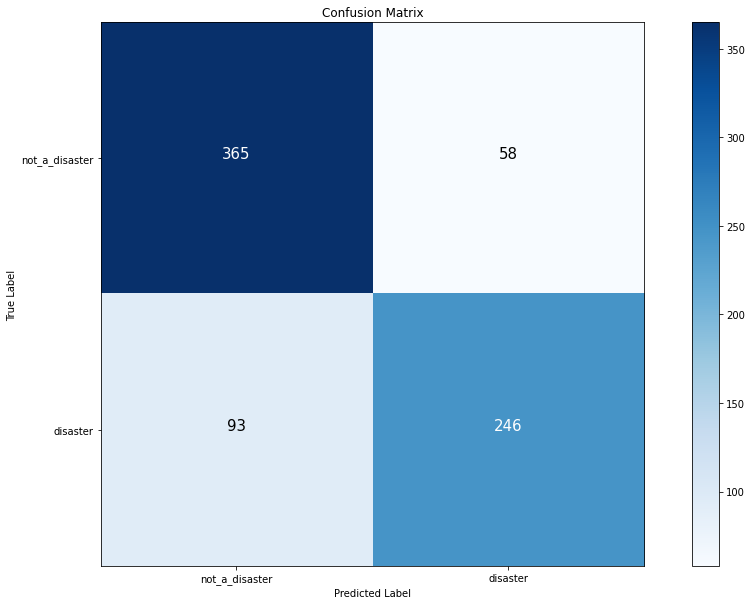

In [49]:
# predictions on the validation sentences
val_preds = model_predictions(model_USE, val_sentences)

# creating an array of class name
class_names = ['not_a_disaster', 'disaster']

# plot the confusion matrix
make_confusion_matrix(y_true=val_labels,
                      y_pred=val_preds,
                      classes=class_names,
                      figsize=(17 ,10),
                      saveFig=True,
                      text_size=15)